Following Eric's instruction, visualising some processed data inSLAC Jupyter is the goal of this notebook
https://confluence.slac.stanford.edu/pages/viewpage.action?pageId=245696522

Import Butler

see the detailed description https://pipelines.lsst.io/modules/lsst.daf.butler/index.html

In [1]:
from lsst.daf.butler import Butler

Set the path to the Butler repository and import a Butler

In [2]:
repo_path = "/sdf/group/lsst/camera/IandT/repo_gen3/spot_test/butler.yaml"
butler = Butler(repo_path)

Walt through the butler database by following
https://github.com/LSSTScienceCollaborations/StackClub/blob/master/Basics/Gen3ButlerTutorial.ipynb

In [3]:
registry = butler.registry

In [4]:
for c in registry.queryCollections():
    print(c)    

LSSTCam/raw/all
u/echarles/calib/run_12781
u/echarles/calib/run_12781/20210322T182107Z
/calib/run_12781
u/echarles/calib/bias/run_12781
u/echarles/calib/bias/run_12781/20210322T183606Z
LSSTCam/calib
LSSTCam/calib/unbounded
u/echarles/calib/run_12783/dark
u/echarles/calib/run_12783/dark/20210322T202029Z
u/echarles/calib/defects/run_12781
u/echarles/calib/defects/run_12781/20210322T224240Z
u/echarles/sandbox/eo_bias
u/echarles/sandbox/eo_bias/20210324T033754Z
u/echarles/calib/bias/run_12781/20210324T162502Z
u/echarles/calib/run_12783/dark/20210324T163856Z
u/echarles/calib/defects/run_12781/20210324T164529Z
u/youtsumi/spot/20210324
u/youtsumi/spot/20210324/20210325T013830Z
u/youtsumi/spot/20210324a
u/youtsumi/spot/20210324a/20210325T034308Z
u/youtsumi/spot/20210324c
u/youtsumi/spot/20210324c/20210325T041707Z
u/echarles/calib/bias/run_12781/20210326T180033Z


pick one of those and put in collections below

In [5]:
#collections = 'u/youtsumi/spot/20210324c'
collections = 'u/echarles/calib/bias/run_12781/20210326T180033Z'
subbutler = Butler(repo_path,collections=collections)
subregistry = subbutler.registry
for dtype in subregistry.queryDatasetTypes():
    try:
        datasetRefs = list(subregistry.queryDatasets(datasetType=dtype,collections=collections))        
        print(len(datasetRefs), dtype )
    except:
        print("Error", dtype )

0 DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('cpBiasProc_full', {band, instrument, detector, physical_filter, exposure}, Exposure)
25 DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
0 DatasetType('bias_full', {instrument, detector}, ExposureF, isCalibration=True)
1 DatasetType('cpCombine_metadata', {instrument, detector}, PropertySet)
1 DatasetType('isr_config', {}, Config)
1 DatasetType('cpCombine_config', {}, Config)
1 DatasetType('packages', {}, Packages)
25 DatasetType('cpBiasProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
1 DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True)
0 DatasetType('cpDarkIsr', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('cpDarkProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('cpDark_metadata', {band, instrument, detector, physic

In [6]:
datasetRefs = list(subregistry.queryDatasets(datasetType="bias",collections=collections))        
datasetRefs[0].dataId

{instrument: LSSTCam, detector: 30}

In [7]:
calexp = subbutler.get(datasetRefs[0])

ValueError: Failure from formatter 'lsst.obs.base.formatters.fitsExposure.FitsExposureFormatter' for dataset 80299 (bias from file:///sdf/group/lsst/camera/IandT/repo_gen3/spot_test/u/echarles/calib/bias/run_12781/20210326T180033Z/bias/bias_LSSTCam_R10_S10_u_echarles_calib_bias_run_12781_20210326T180033Z.fits): 
  File "src/image/ExposureFitsReader.cc", line 67, in lsst::afw::image::ExposureFitsReader::MetadataReader::MetadataReader(std::shared_ptr<lsst::daf::base::PropertyList>, std::shared_ptr<lsst::daf::base::PropertyList>, const Point2I&)
    Cannot read Exposure FITS version >= 1 {0}
lsst::pex::exceptions::TypeError: 'Cannot read Exposure FITS version >= 1'


In [8]:
%matplotlib inline

import pylab as plt
# Stack imports
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay
# And plot!

In [9]:
afwDisplay.setDefaultBackend('matplotlib') 
fig = plt.figure(figsize=(10,10))
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(calexp)
#plt.gca().axis('off')

NameError: name 'calexp' is not defined

<Figure size 720x720 with 0 Axes>

In [11]:
from astropy.io import fits
fh = fits.open("/sdf/group/lsst/camera/IandT/repo_gen3/spot_test/u/echarles/calib/bias/run_12781/20210326T180033Z/bias/bias_LSSTCam_R10_S10_u_echarles_calib_bias_run_12781_20210326T180033Z.fits")

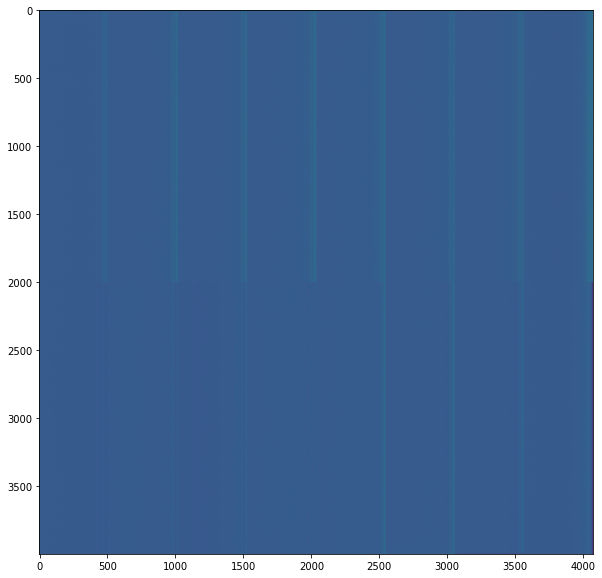

In [12]:
fig = plt.figure(figsize=(10,10))
plt.imshow(fh[1].data)